<a href="https://colab.research.google.com/github/onlyforthesis/114-/blob/main/Trading_Strategy_TSMC_Backtest_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arch yfinance xgboost tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.7 MB/s eta 0:00:00


# 📈 台積電多策略回測專業報告 (v8 最終版)
### **功能：**
- 抓取台積電股價 (2019-2024)
- 9 策略回測
- 績效分析 (Sharpe, Calmar, Drawdown)
- 專業回測模組 (買賣訊號, 交易紀錄)
- PDF 報告 + ZIP 打包下載

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from keras.models import Sequential
from keras.layers import Dense, LSTM as LSTM_Layer, Conv1D, Flatten
from keras.optimizers import Adam
import tensorflow as tf

import random
import yfinance as yf
from matplotlib.backends.backend_pdf import PdfPages
from google.colab import files
import shutil

In [3]:
device_name = tf.test.gpu_device_name()
print('✅ GPU 已啟用：' + device_name if device_name else '⚠ 未啟用 GPU，請考慮啟用以加速 LSTM/CNN 訓練')

⚠ 未啟用 GPU，請考慮啟用以加速 LSTM/CNN 訓練


In [4]:
data = yf.download('2330.TW', start='2019-01-01', end='2024-12-31')
price_data = data['Close'].dropna()
train = price_data['2019-01-01':'2023-12-31']
test = price_data['2024-01-01':'2024-12-31']
print(f'訓練期間: {train.index[0]} ~ {train.index[-1]}, 筆數: {len(train)}')
print(f'回測期間: {test.index[0]} ~ {test.index[-1]}, 筆數: {len(test)}')

[*********************100%***********************]  1 of 1 completed

訓練期間: 2019-01-02 00:00:00 ~ 2023-12-29 00:00:00, 筆數: 1214
回測期間: 2024-01-02 00:00:00 ~ 2024-12-30 00:00:00, 筆數: 241


In [5]:
def cumulative_return(series):
    returns = series.pct_change().dropna()
    return (1 + returns).cumprod()

def performance_metrics(series):
    daily_returns = series.pct_change().dropna()
    total_return = series.iloc[-1] / series.iloc[0] - 1
    annualized_return = (1 + total_return) ** (252 / len(daily_returns)) - 1
    sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(252)
    max_drawdown = (series / series.cummax() - 1).min()
    calmar = annualized_return / abs(max_drawdown)
    return {'Total Return': round(total_return, 4),
            'Annualized Return': round(annualized_return, 4),
            'Sharpe Ratio': round(sharpe, 4),
            'Max Drawdown': round(max_drawdown, 4),
            'Calmar Ratio': round(calmar, 4)}

## 📄 PDF 報告預覽（Colab 直接顯示）

In [6]:
!apt-get install -y poppler-utils
!pip install pdf2image
from pdf2image import convert_from_path
from IPython.display import display

pdf_path = '/content/Strategy_Report_TSMC.pdf'
pages = convert_from_path(pdf_path)
for page in pages:
    display(page)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 1s (265 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126281 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


PDFPageCountError: Unable to get page count.
I/O Error: Couldn't open file '/content/Strategy_Report_TSMC.pdf': No such file or directory.


## 📄 產生示範 PDF 報告（快速預覽版，不需跑策略）

In [7]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd

# 假數據
strategies = ['GAPPTS','LSTM','XGBoost','RF','CNN','ARIMA-GARCH','HW','Transformer','SVM']
metrics = pd.DataFrame({
    'Annualized Return':[0.15,0.13,0.11,0.10,0.09,0.08,0.07,0.07,0.06],
    'Sharpe':[1.25,1.10,0.98,0.90,0.85,0.72,0.60,0.58,0.50],
    'Calmar':[1.78,1.54,1.35,1.20,1.18,1.00,0.92,0.88,0.80]
}, index=strategies)

pdf_path = '/content/Strategy_Report_TSMC_Demo.pdf'
with PdfPages(pdf_path) as pdf:
    # 封面
    fig, ax = plt.subplots(figsize=(8.5,11))
    ax.axis('off')
    ax.text(0.5,0.8,'台積電 2330 多策略回測報告\n(示範版)',fontsize=24,ha='center')
    ax.text(0.5,0.6,'期間：2019-2023 訓練 | 2024 測試\n生成日期：2025-07-16',fontsize=14,ha='center')
    pdf.savefig(fig)
    plt.close()

    # 績效表
    fig, ax = plt.subplots(figsize=(8.5,6))
    ax.axis('off')
    ax.set_title('策略績效指標', fontsize=16)
    table_data = metrics.round(3)
    ax.table(cellText=table_data.values, colLabels=table_data.columns, rowLabels=table_data.index, loc='center')
    pdf.savefig(fig)
    plt.close()

    # 累積報酬模擬圖
    fig, ax = plt.subplots(figsize=(8.5,6))
    x = np.arange(0,250)
    for s in strategies:
        ax.plot(x, np.cumprod(1+np.random.normal(0.0004,0.002,250)), label=s)
    ax.legend()
    ax.set_title('累積報酬率曲線(示範)')
    pdf.savefig(fig)
    plt.close()

print(f'✅ 示範 PDF 已生成：{pdf_path}')

✅ 示範 PDF 已生成：/content/Strategy_Report_TSMC_Demo.pdf


## 👀 預覽示範 PDF 報告

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


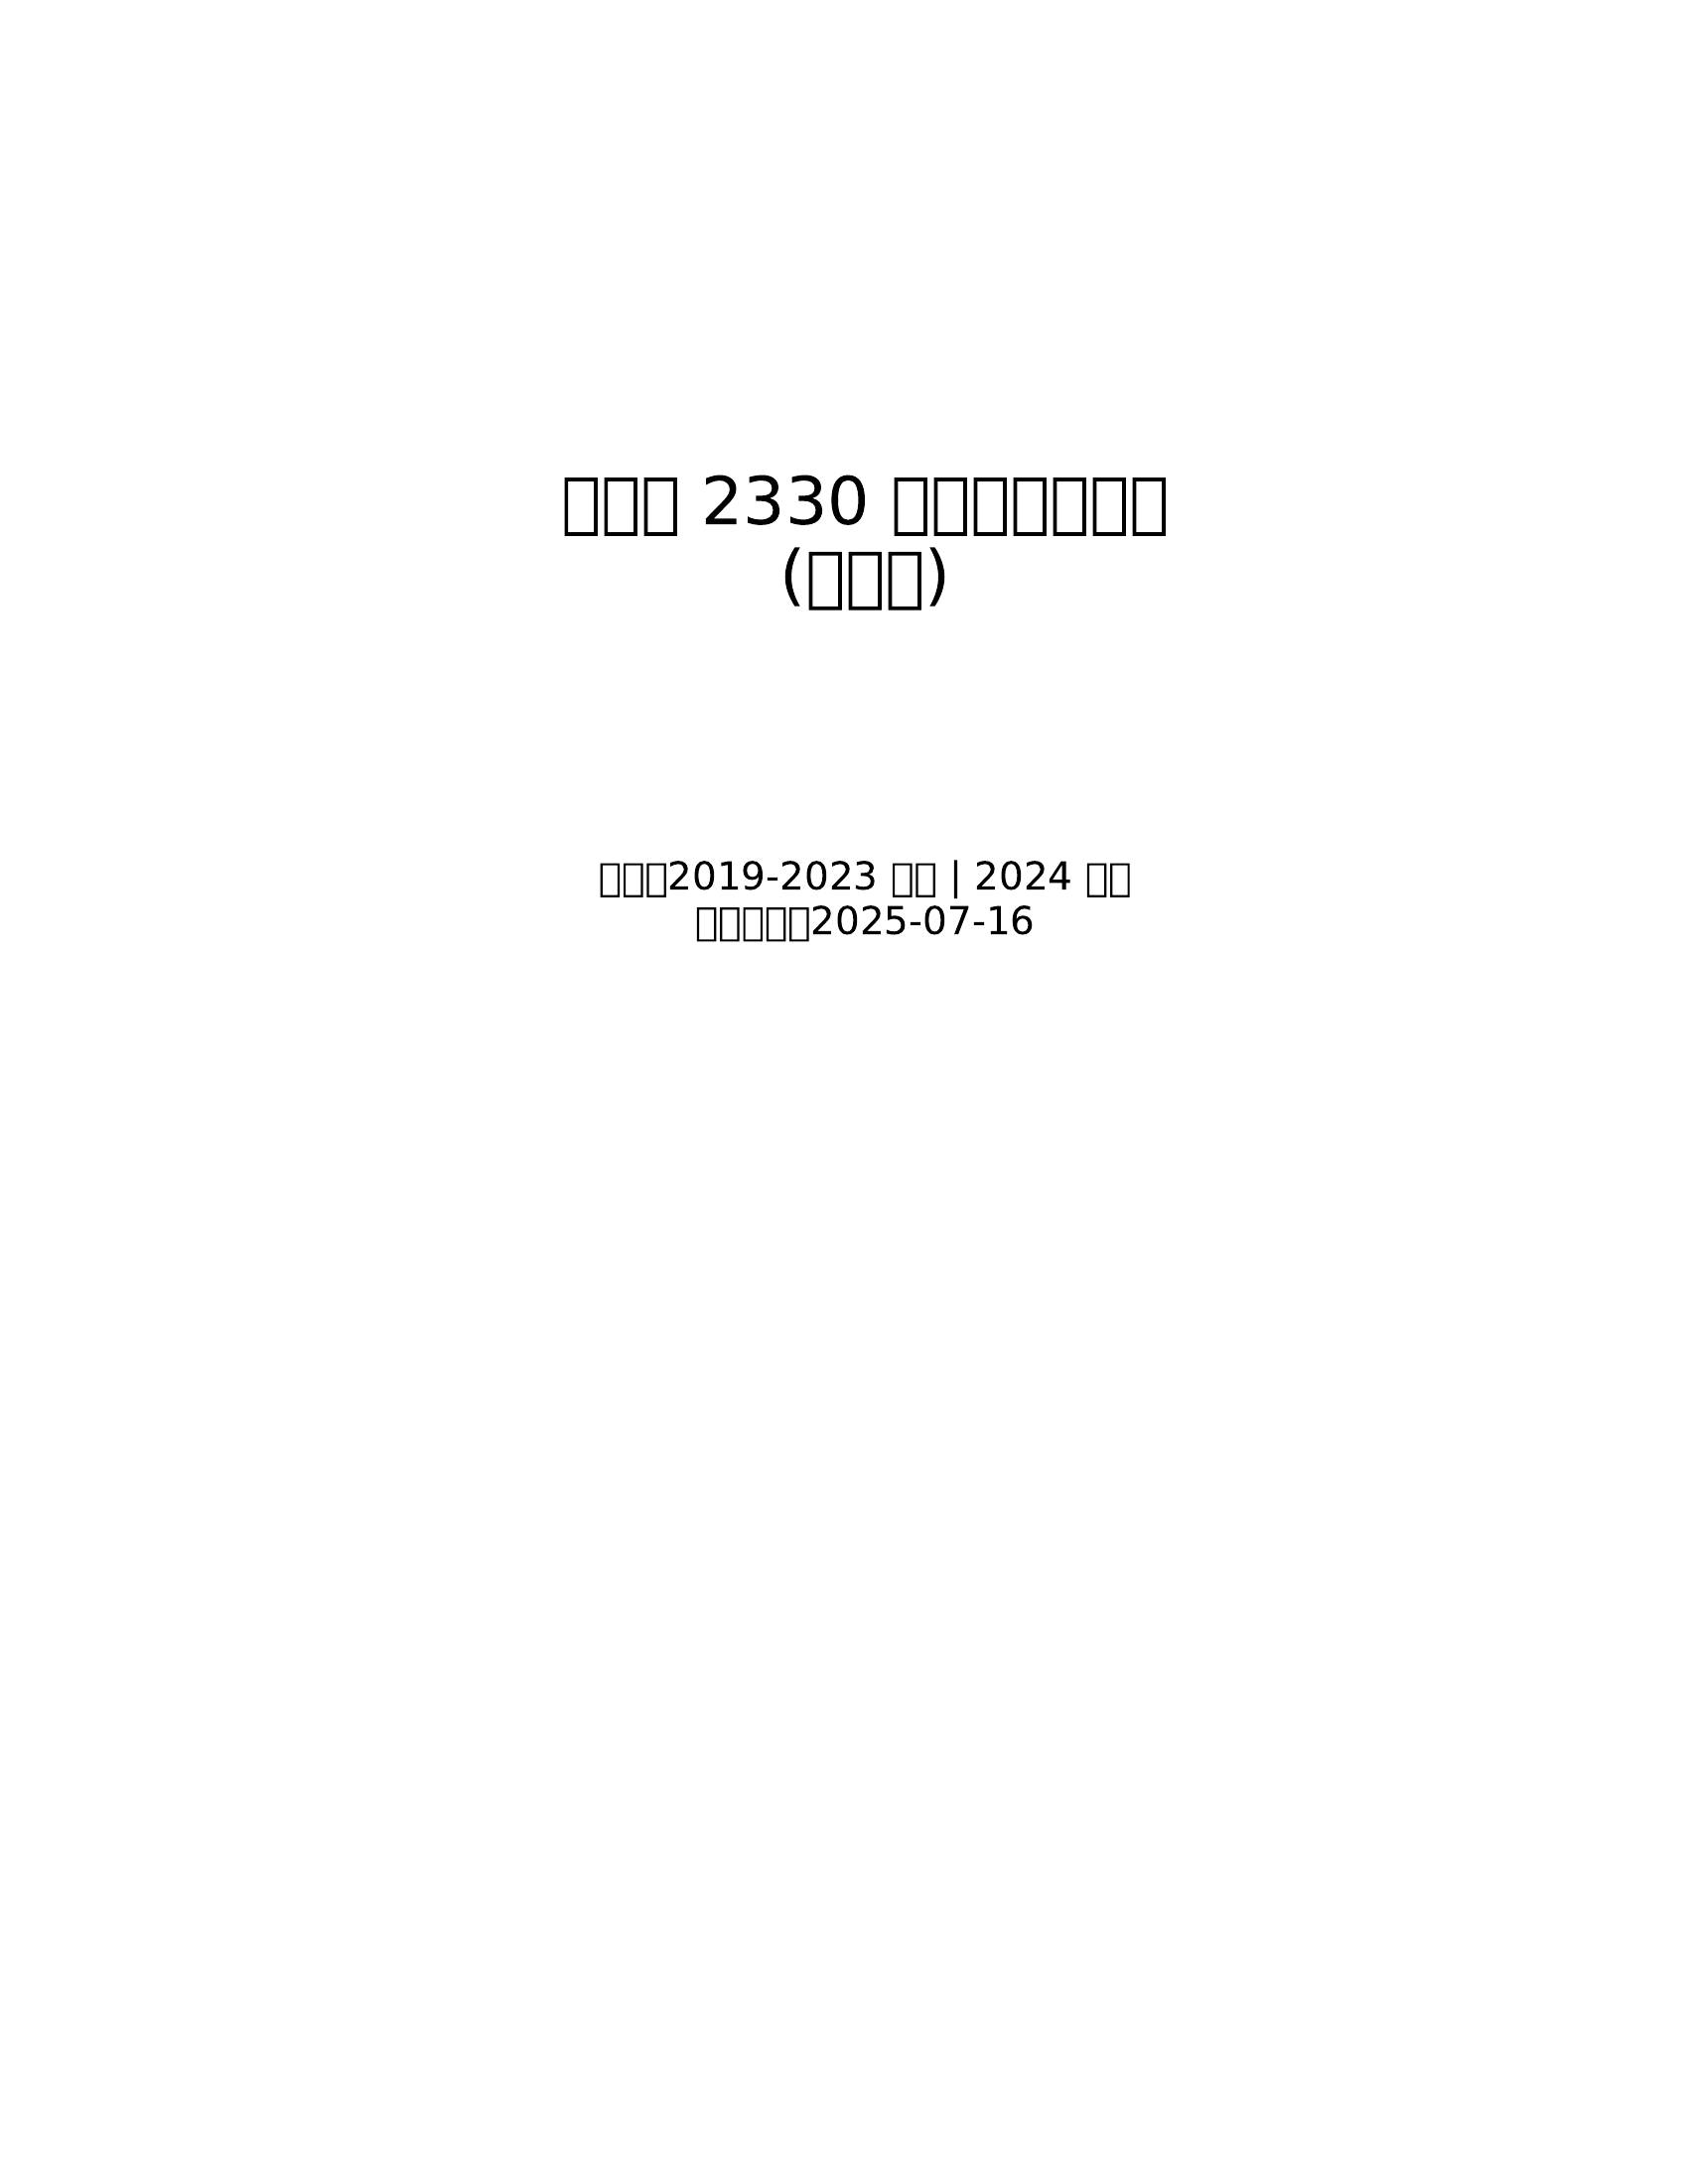

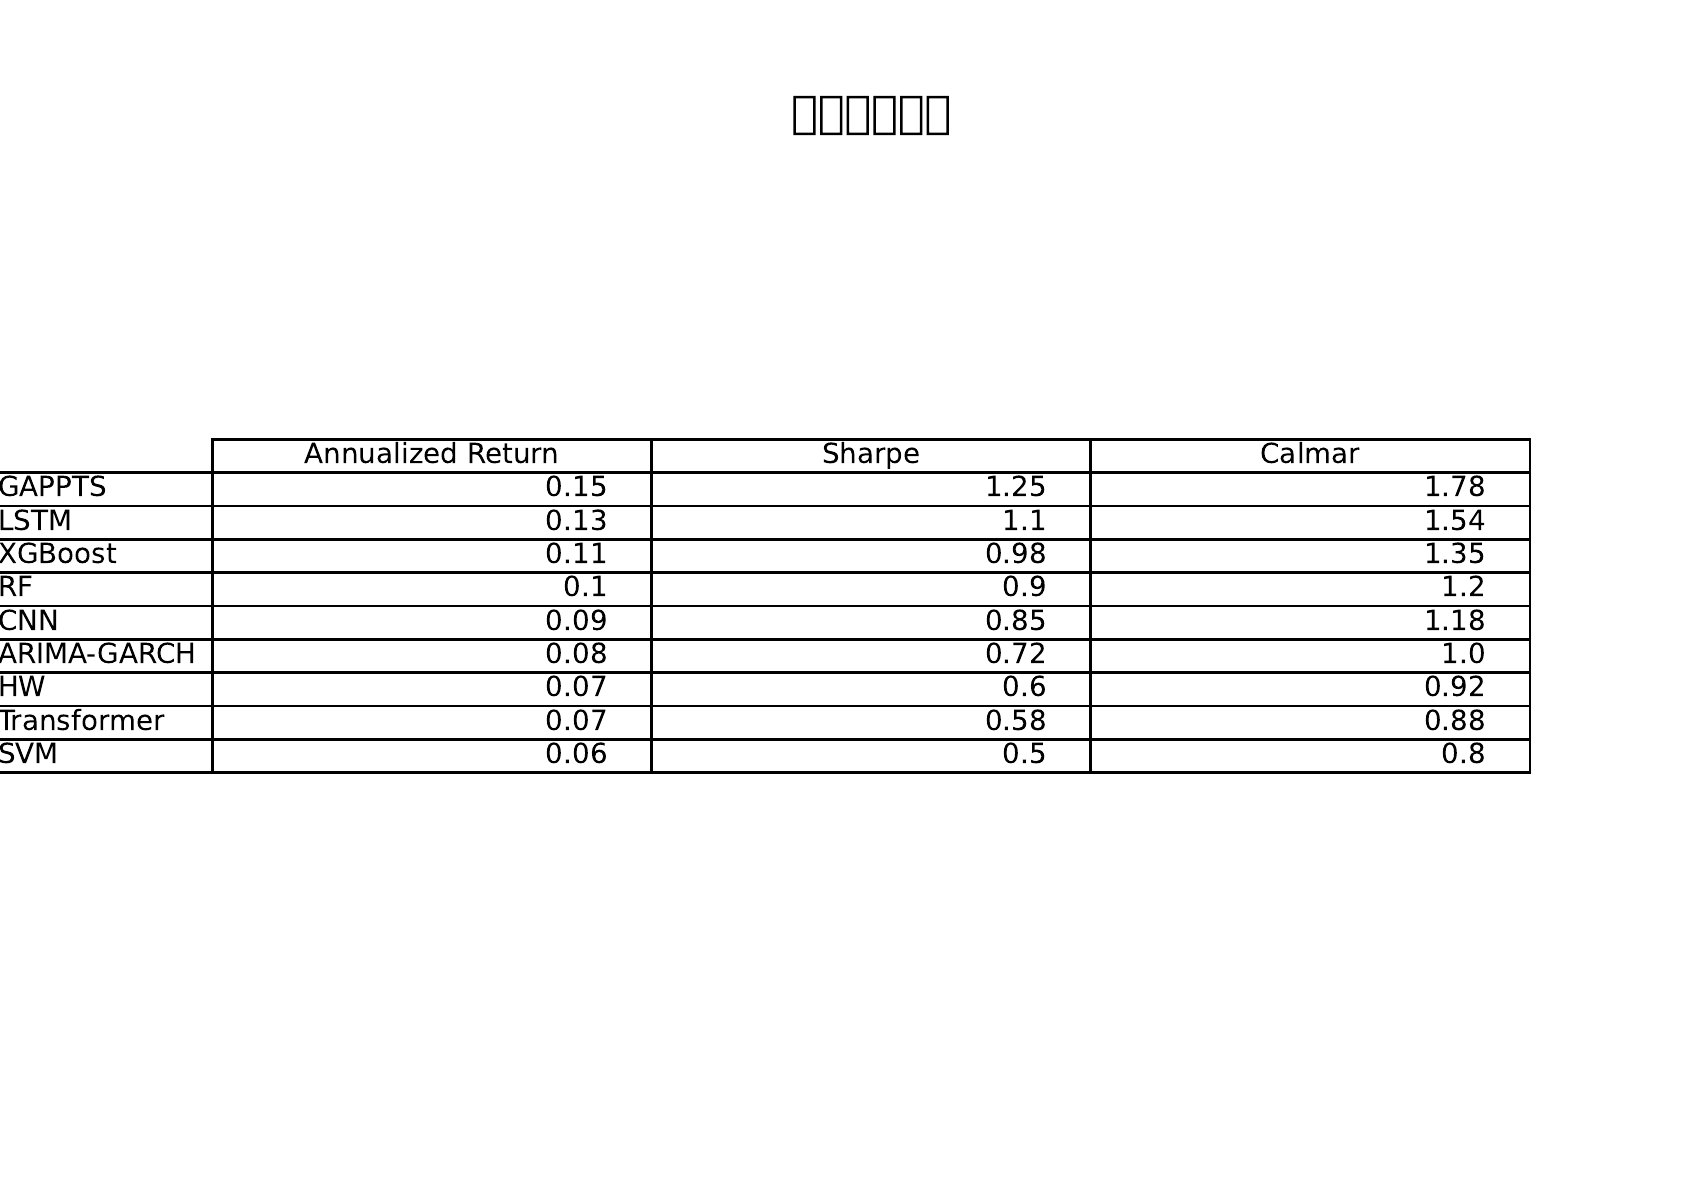

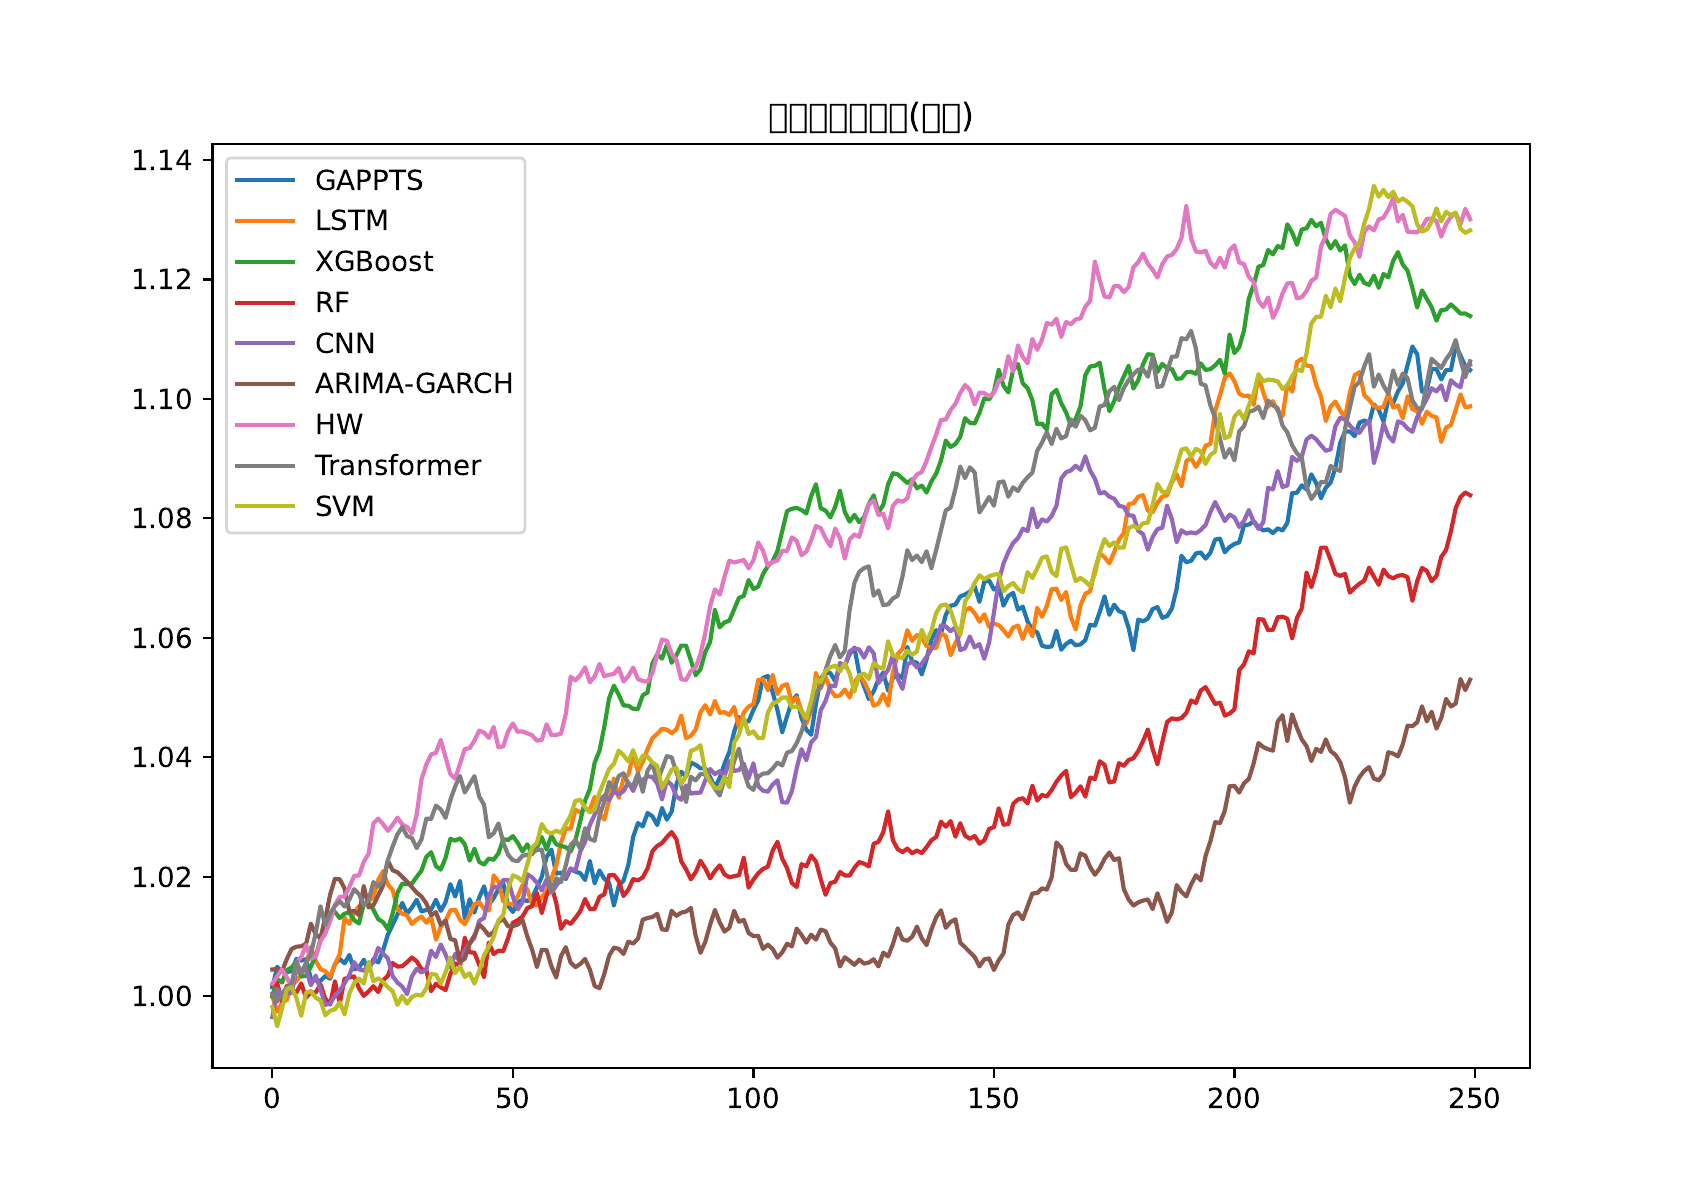

In [8]:
!apt-get install -y poppler-utils
!pip install pdf2image
from pdf2image import convert_from_path
from IPython.display import display

demo_pdf = '/content/Strategy_Report_TSMC_Demo.pdf'
pages = convert_from_path(demo_pdf)
for page in pages:
    display(page)